# Project 4 - Part 1 Regression Analysis

Gorkem Camli (105709280)

#### Library imports

In [146]:
import pandas as pd
import numpy as np
import random
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

import statsmodels.api as sm
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from subprocess import call

import lightgbm as lgb
import joblib
import os.path

import warnings
warnings.filterwarnings('ignore')

In [2]:
 %matplotlib inline 
sns.set_style("whitegrid")

In [3]:
rand_seed = 142
np.random.seed(rand_seed)
random.seed(rand_seed)

#### Dataset Exploration

Diamonds Data

In [4]:
diamonds_df = pd.read_csv('diamonds.csv', index_col=0)
print(diamonds_df.shape)
diamonds_df.head()

(53940, 10)


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    338  4.34  4.35  2.75

In [5]:
diamonds_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Gas Turbine CO and NOx Emission Data

In [6]:
repo_name = 'pp_gas_emission/'
file_names= ['gt_2011.csv',
             'gt_2012.csv',
             'gt_2013.csv',
             'gt_2014.csv',
             'gt_2015.csv'
]

gas_partial_dfs = []
for file_name in file_names:
    year = file_name[file_name.find('_')+1: file_name.find('.')]
    year_df = pd.read_csv(repo_name+file_name)
    year_df['year']= year
    gas_partial_dfs.append(year_df)


gas_df = pd.concat(gas_partial_dfs)
print(gas_df.shape)
gas_df.head()

(36733, 12)


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  year  
0  0.32663  81.952  2011  
1  0.44784  82.377  2011  
2  0.45144  83.776  2011  
3  0.23107  82.505  2011  
4  0.26747  82.028  2011

In [7]:
gas_df.describe()

AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX  
count  36733.000000  
mean      65.293067  
std       11.678357  
min       25.905000  
25%       57.162000  
50%       63.849000  
75%       71.548000  
max      119.910000

In [8]:
gas_df.describe(include=['category','object'])

year
count   36733
unique      5
top      2012
freq     7628

In [9]:
gas_df = gas_df.drop(columns=['CO'])
gas_df.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

      NOX  year  
0  81.952  2011  
1  82.377  2011  
2  83.776  2011  
3  82.505  2011  
4  82.028  2011

## Before Training

### Standardization

#### Question 1

For diamonds data, all the categorical features are quality features, therefore I used Ordinal Encoder to encode them. While encoding the given labels, I specified the ordering from low to high quality for the cut, color, clarity features. For example, for cut categories: Fair gets the lowest label number whereas Ideal got the highest. Later, for both categorical and numerical features, standard scaler is applied. Target variable is kept same.

In [10]:
# get feature names by type
diamonds_num_cols =  diamonds_df.select_dtypes(include=['int64', 'float64']).drop(['price'], axis=1).columns
diamonds_cat_cols = diamonds_df.select_dtypes(include=['object', 'category']).columns

print(diamonds_num_cols)
print(diamonds_cat_cols)

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')
Index(['cut', 'color', 'clarity'], dtype='object')


In [11]:
# create a feature transformer for each type of features
cut_categories = ['Fair', 'Good','Very Good', 'Premium','Ideal']
color_categories = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_categories = ['I1','SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds_categs_order = [cut_categories, color_categories, clarity_categories]
    
def feature_transformer_diamonds(data, numeric_feats, categ_feats, diamonds_categs_order, scale=True):
    cat_transformer_ordinal = Pipeline(steps=[('ordinal_enc', OrdinalEncoder(categories=diamonds_categs_order))])
    data[categ_feats] = cat_transformer_ordinal.fit_transform(data[categ_feats])
    if scale:
        num_transformer = Pipeline(steps=[('std_scaler', StandardScaler())])
        data[list(numeric_feats)+list(categ_feats)] = num_transformer.fit_transform(data[list(numeric_feats)+list(categ_feats)]) # TODO check data[numeric_feats+categ_feats] 
        
    #preprocessor = ColumnTransformer(transformers= [('num_transformer', num_transformer, numeric_feats),
    #                                               ('cat_transformer', cat_transformer_ordinal, categ_feats)])
    
    return data


In [12]:
print("Raw Diamonds Data")
display(diamonds_df.head(4))
diamonds_prep_df= diamonds_df.copy()
diamonds_prep_df = feature_transformer_diamonds(data=diamonds_prep_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=True)
print("Diamonds Data After Standardization and Category Feature Encoding")
diamonds_prep_df.head(4)

Raw Diamonds Data


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63

Diamonds Data After Standardization and Category Feature Encoding


carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   

          x         y         z  
1 -1.587837 -1.536196 -1.571129  
2 -1.641325 -1.658774 -1.741175  
3 -1.498691 -1.457395 -1.741175  
4 -1.364971 -1.317305 -1.287720

In [13]:
print('Description of Diamonds data after standardization')
diamonds_prep_df.describe()

Description of Diamonds data after standardization


carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

In [14]:
diamonds_unscaled_df = diamonds_df.copy()
diamonds_unscaled_df = feature_transformer_diamonds(data=diamonds_unscaled_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=False)
#diamonds_unscaled_df.describe()

### Profiling Results

Pandas profiling is used to explore the dataset for both diamonds and gas dataset. The results can be seen below:

In [15]:
#profile_diamonds = ProfileReport(diamonds_df)
#profile_diamonds

In [16]:
#profile_gas = ProfileReport(gas_df)
#profile_gas

### Data Inspection

To further understand the data I did fata inspection and answered the following questions:

#### Question 2

For both datasets heatmap with pearson correlation is plotted:

In [17]:
def heat_map(data_df, data_name=''):
    plt.figure(figsize=(10,10))
    corr = data_df.corr(method='pearson')
    sns.heatmap(corr, annot=True, linewidths=1)
    plt.title(data_name+' Heatmap ')
    plt.show()

__Diamonds Data:__

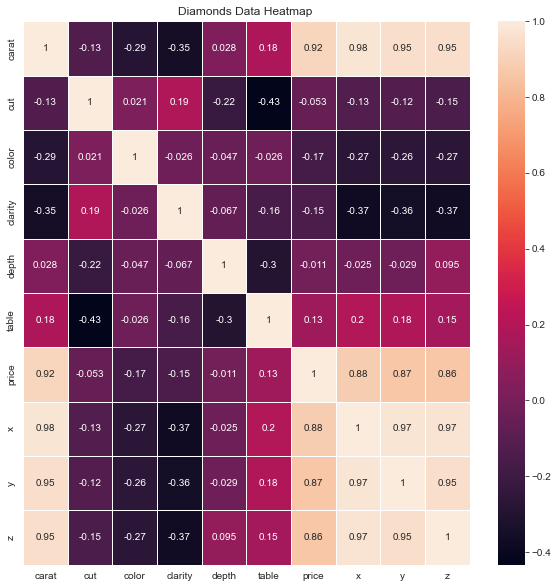

In [18]:
heat_map(data_df=diamonds_prep_df, data_name='Diamonds Data')

For Pearson correlation the values are between -1 to 1. Values closer -1 means strong negative correlation, values closer 1 means strong positive correlation and values closer to 0 means low correlation. High correlation means there is a strong linear relationship between two variables. If it is closer to 1, means increasing one variable we expect increase in the other. If the value is closer to -1, high negative correlation, increasing one variable will result in the decrease of the other variable. Having a value close to 0 means that there is no strong linear relation betweeen the two variables, changing one doesn't have a clear effect on the other as a direct increase or decrease. Having a pearson correlation 0 or close to 0 doesn't mean there is no relationship between the two, a nonlinear relationship may exist, it is just that we cannot tell nonlinear relationship by just looking Pearson correlation. 

In the diamonds data Pearson Correlation heatmap, we see high correlation on carat,x, y, z and price columns. The pearson correlation values between price and carat is 0.92, x=0.88, y=0.87 and z=0.86. Carat seems to be the most important feature to tell the diamond price. The high correlation suggest carat, x, y, z values are the most predictive features for predicting the price of a diamond. The pearson correlation for these features are positive for target variable price. This means there is a positive relationship between these variables and price, hence the increasing any of these 4 features will lead the diamond price to be higher. These makes sense in the real world as well since the bigger diamonds (dimensions x,y,z) and/or carat (weight) are generally more expensive.

TODO explain

#### Question 3

Histogram of the numerical features for each dataset can be seen below:

In [19]:
def histogram_num_features(data, num_feats, data_name, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Numerical Features Histogram')
    for num_feat, ax_ind in zip(num_feats, ax.ravel()):
        sns.histplot(data, x=num_feat, ax=ax_ind)
        ax_ind.set_title(f'{num_feat} Histogram')
    plt.show()


__Diamond Dataset:__

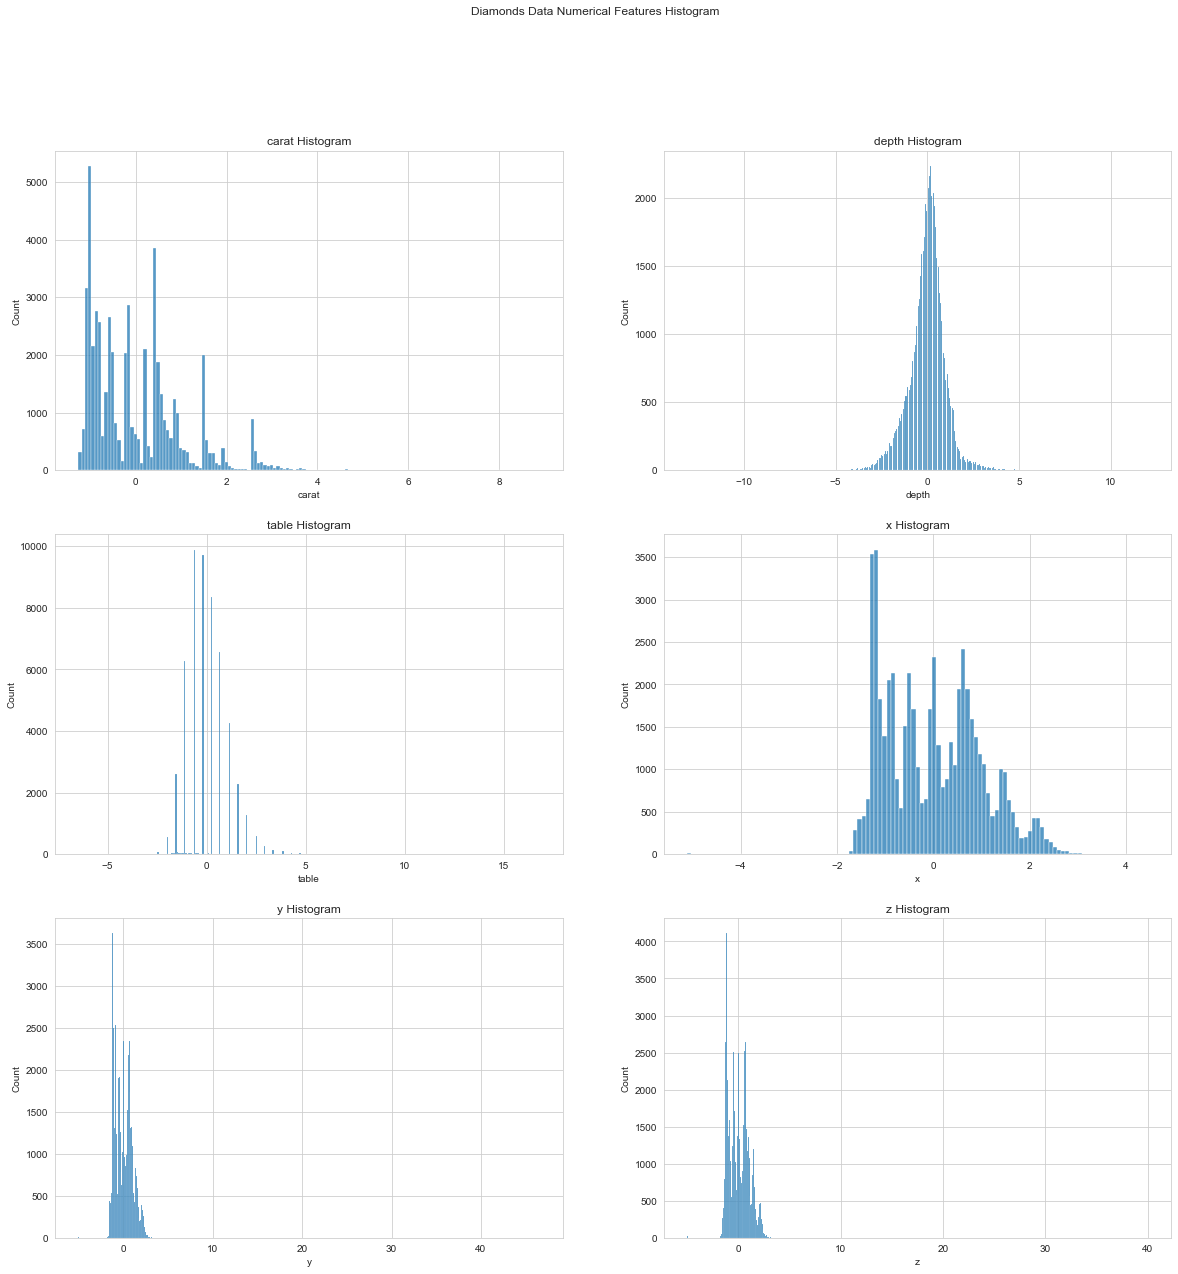

In [20]:
histogram_num_features(data=diamonds_prep_df,num_feats=diamonds_num_cols, data_name='Diamonds Data', 
                       num_rows=3, num_cols=2, fig_size=(20,20))

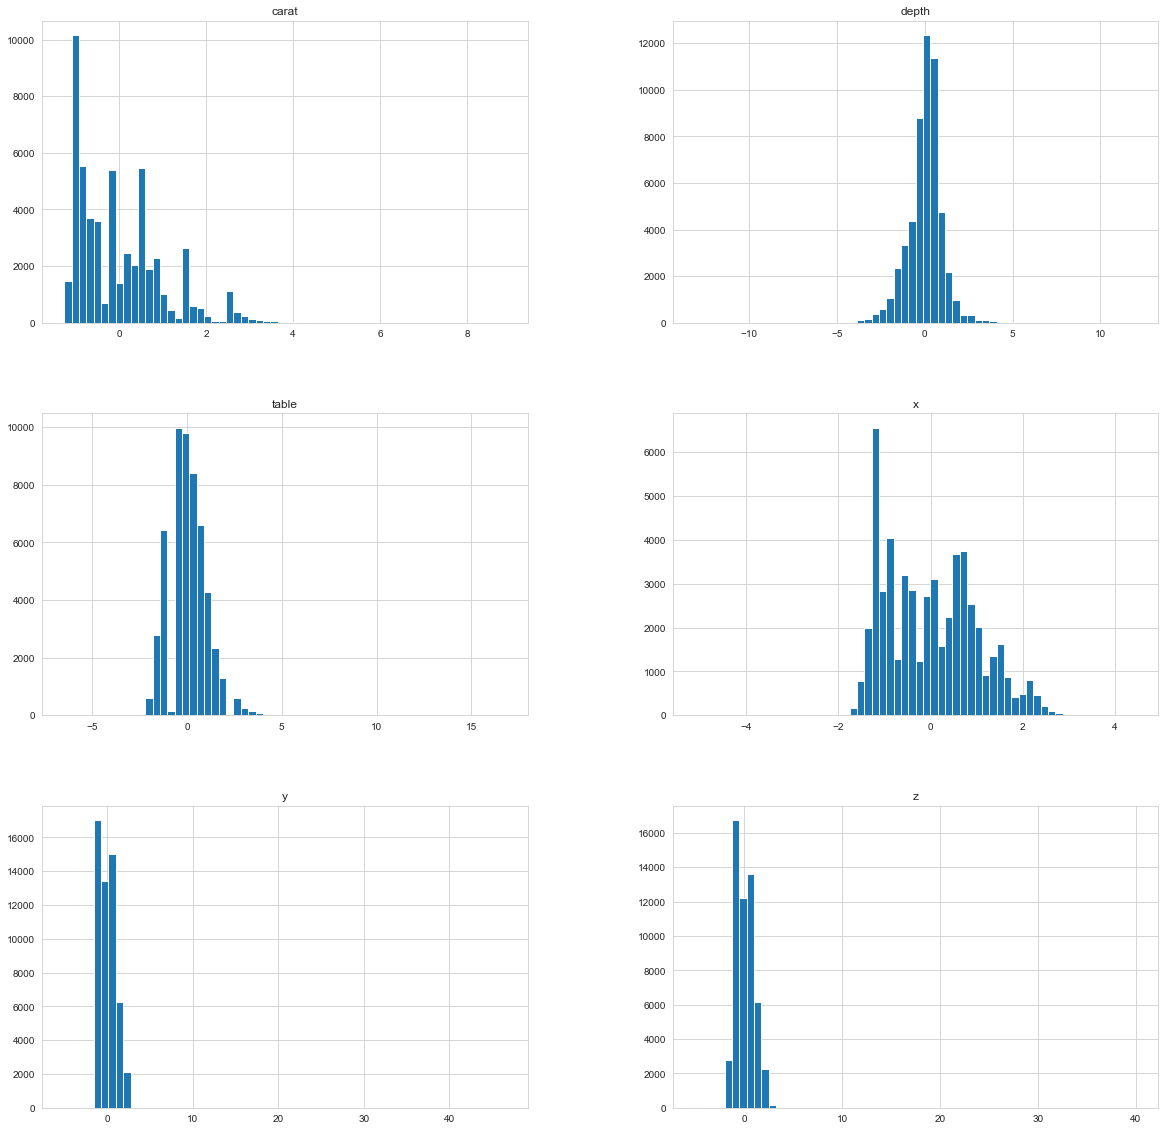

In [21]:
diamonds_prep_df[diamonds_num_cols].hist(figsize=(20, 20), bins=60)
plt.show()

In [22]:
diamonds_prep_df.describe()

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

TODO answer q

__Diamond Data:__

Carat and x features' histogram seems to be right skewed. Y and z plots have few outliers around 40 and they don't seem to follow gaussian distribution. Depth and table seems to be close to normal distribution.
 

__What preprocessing can be done if the distribution of a feature has high skewness?__

There are different ways to handle high skewed data and reduce its skewness:

1- Log Transform (natural log)   
2- Square root transform    
2- Box-Cox transformation   

There are different transformation possibilities to address the skewness of the data, and it is difficult to determine which one needs to be applied. This generally depends highly on the current doistribution of the data. Box-Cox transformation is a family of transformations where you select $\lambda$ value typically from -5 to 5. Optimal $\lambda$ is chosen based on the data where its transformation is the best approximation of a normally distributed curve. The transformation of data y is simply $y_\text{transformed} = y^\lambda$. 

 $\lambda=0$ corresponds to the natural log of the data.    
 $\lambda=0.5$ corresponds to the square root transform of the data.
 
 Hence, the first two approach is also contained within the Box-Cox transformation family.
 
 By applying Box-Cox Transformation one can decrese the high skewness and make the data distribution closer to normal distribution.

#### Question 4

Box plot of categorical features in each dataset against target variable. For each dataset I plotted two boxplots one with fliers and the other one without fliers (showfliers=False to not show outliers). I added the plots without fliers as I noticed that there are extreme values that stretch the plots too much and makes the boxplots compact, by not showing outliers, I can zoom in the boxplot itself to visually better see the differences between category values. 

In [23]:
def boxplot_cat_features(data, cat_feats, target_feature, data_name, num_rows, num_cols, fig_size, showfliers=True):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Categorical Features Boxplot against target variable ({target_feature})')
    for cat_feat, ax_ind, cat_order in zip(cat_feats, ax.ravel(), diamonds_categs_order):
        sns.boxplot(data=data, x=cat_feat, y=target_feature,  ax=ax_ind, order=cat_order, showfliers=showfliers)
    plt.show()

__Diamonds Data:__

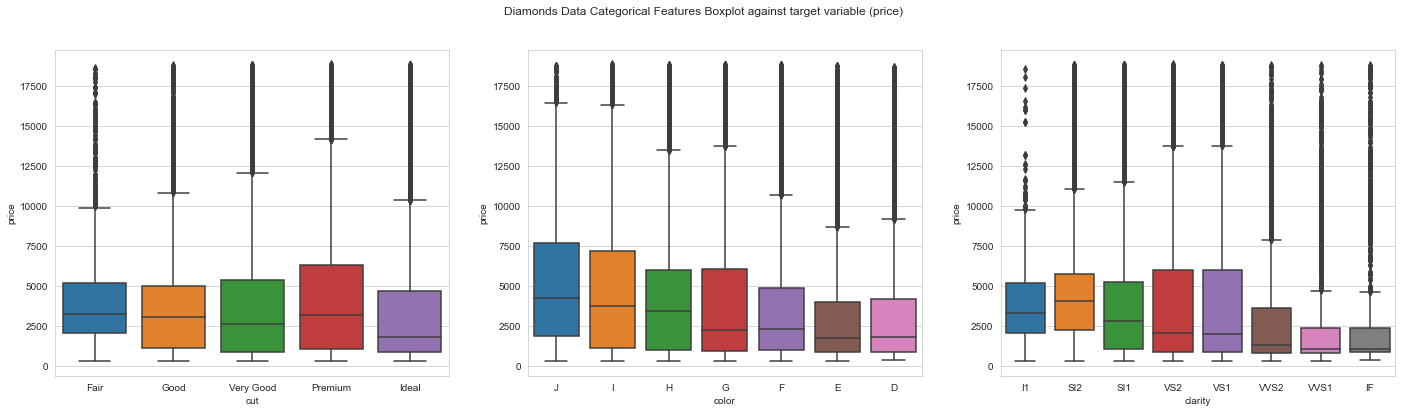

In [25]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, 
                     target_feature='price', data_name='Diamonds Data',
                     num_rows=1, num_cols=3, fig_size=(24,6))

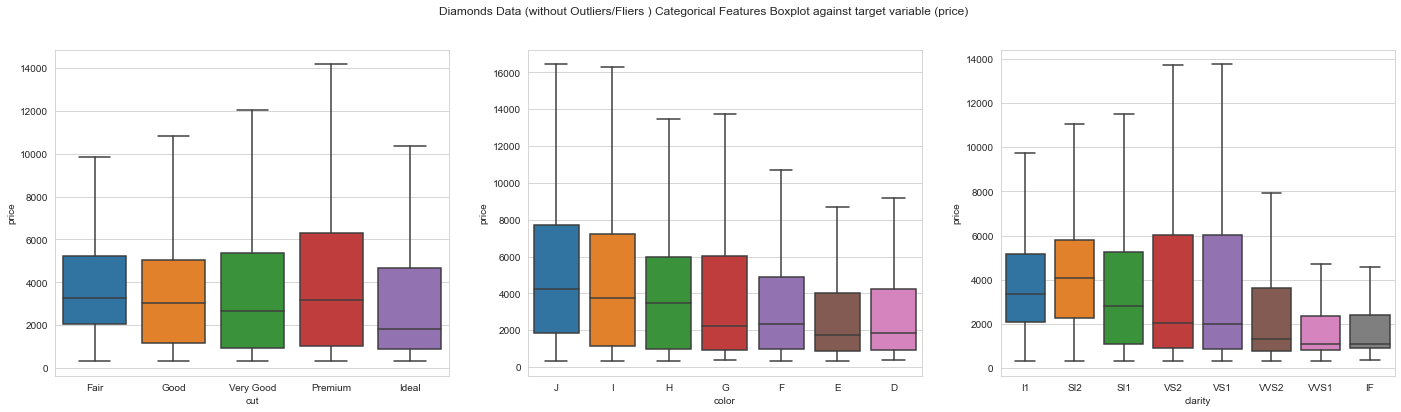

In [26]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, 
                     target_feature='price', data_name='Diamonds Data (without Outliers/Fliers )',
                     num_rows=1, num_cols=3, fig_size=(24,6), showfliers=False)

TODO answer q

__Diamond Dataset:__

Cut boxplots: The minimum of the cut categories are all very close. The median values are close to each other except for the Ideal cut where the median price is lower compared to its counterparts. One surprising thing to see is that even though Ideal is the best quality, the median, 3rd percentile and maximum (Q3+1.5*IQR) prices are lower compared to Premium and Very Good cut categories. Premium cut has a higher  3rd percentile and maximum (Q3+1.5*IQR) values compared to other categories. All cuts have outlier prices that goes as high as around 17500. From the plot, we can say that the median and minimum price ranges are similar between cut types, but . 

Color boxplots: J color seems to have higher prices since its 1st quartile, median and 3rd quartile are higher than its counter parts. If we group colors by similar price distributions we can say that J,I pricing distribution are close to each other, with the highest price distributions and E,D is the colors where diamond prices are lower overall. Though outliers exists for all color types that has peak prices. For lower color quality the median and 3rd quartile prices are higher compared to the high quality colors.

Clarity boxplots: This is the variable that has most diverse price distributions on its categories. The highest median and minimum value price belongs to SI2. VS2 and VS1 distiributions looks like very similar, these two types of clarity seems to have a lower median but highest 3rd quartile compared to other clarity levels. Best clarity level IF, price distribution is more compact toward lower price ranges. Again all categories have many outliers. 



#### Question 5

In [24]:
def countplot_cat_features(data, num_feats, data_name,diamonds_categs_order, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Count plots')
    for num_feat, cat_order, ax_ind in zip(num_feats, diamonds_categs_order, ax.ravel()):
        sns.countplot(data=data, x=num_feat,  ax=ax_ind, order=cat_order)
    plt.show()

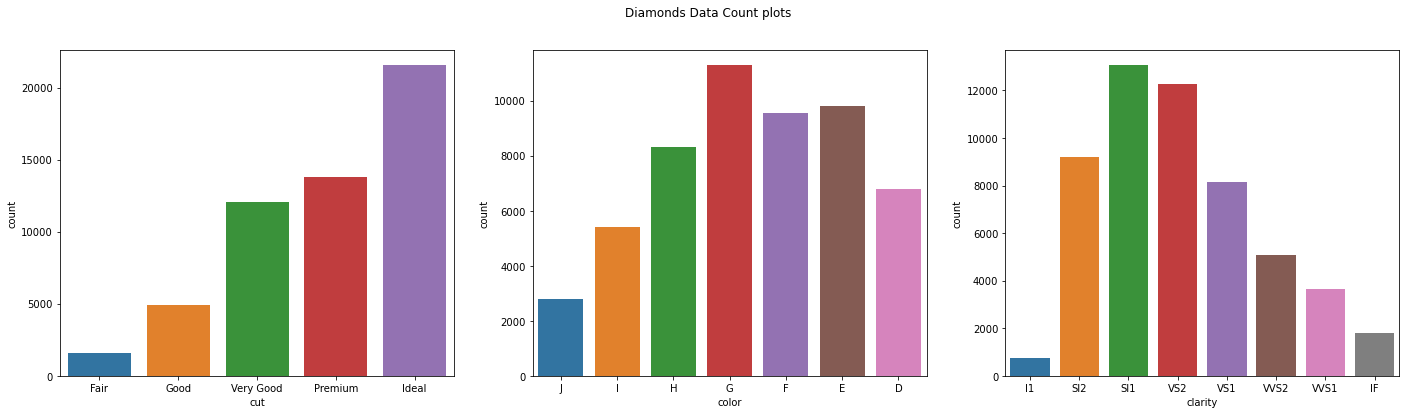

In [25]:
countplot_cat_features(data=diamonds_df, num_feats=diamonds_cat_cols, 
                     data_name='Diamonds Data', diamonds_categs_order=diamonds_categs_order,
                     num_rows=1, num_cols=3, fig_size=(24,6))

__In the diamonds data:__

Cut categories is not equally distributed in the data, ideal cut has the largest sample size. Actually cut quality vs sample size for that cut has positive relationship. Better quality cuts have more samples in the dataset.

Color categories are better distributed in the dataset compared to cut, but still not equally distributed per se. J has the lowest sample count in the dataset whereas G has the highest. Looks like the majority of the data has medium level quality colors.

Clarity variable for the data is uneven as well. The majority of the samples in the dataset lies within SI2, SI1 and VS2 categories (low-medium quality). There are fewer samples for the worst and best clarity diamonds. 

#### Question 6

#### Feature Selection

For this part Mutual Info Regressiong and F regression is used from sklearn library for both datasets. For each preprocessed feature I computed the mutual info and f regression values against target variable.

##### __Question 7__

Mutual Info (MI) Regression calculates the dependency between two vairables and it should be a nonnegative value. 0 means two variables are independent from each other, higher MI values corresponds to higher dependency between the variables. 

F Regreesion performs univariate linear regression tests to capture the relationship between the given variables.

__Diamonds Data Mutual Info Regression & F Regression__

In [51]:
diamond_features = list(diamonds_num_cols)+list(diamonds_cat_cols)
X_diamonds = diamonds_prep_df[diamond_features]
X_diamonds_unscaled = diamonds_unscaled_df[diamond_features]
y_diamonds = diamonds_prep_df['price']

Diamond Features: ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']


In [73]:
# mi regression
mi = mutual_info_regression(X_diamonds, y_diamonds)
mi_scaled = mi / np.max(mi)

# f regression
f_test, _ = f_regression(X_diamonds, y_diamonds)
f_test_scaled = f_test / np.max(f_test)

res_df = pd.DataFrame([diamond_features, mi, mi_scaled, f_test, f_test_scaled ]).T
res_df.rename(columns={0:'Feature Name', 1:'Mutual Info Regression Score',2:'Mutual Info Regression Score - Scaled',
                       3:'F Regression Score',4:'F Regression Score - Scaled'}, inplace=True)
res_df.sort_values(by='Mutual Info Regression Score - Scaled', ascending=False, inplace=True)
res_df

Feature Name Mutual Info Regression Score  \
0        carat                      1.65294   
4            y                      1.42161   
3            x                      1.41344   
5            z                      1.36218   
8      clarity                     0.218607   
7        color                     0.138618   
6          cut                    0.0572714   
2        table                    0.0339318   
1        depth                    0.0308703   

  Mutual Info Regression Score - Scaled F Regression Score  \
0                                     1             304051   
4                              0.860049             160916   
3                              0.855106             193742   
5                              0.824094             154923   
8                              0.132253            1188.01   
7                             0.0838614             1654.4   
6                             0.0346481            154.784   
2                             0.0205281            886.119   
1                              0.018676            6.11586   

  F Regression Score - Scaled  
0                           1  
4                    0.529238  
3                      0.6372  
5                     0.50953  
8                  0.00390726  
7                  0.00544119  
6                 0.000509073  
2                  0.00291437  
1                 2.01146e-05

Table above shows the mutual info and f regression reasult for each variable against target variable price. Table is ordered by Mutual Info Regression Score - Scaledcolumn. The feature importance 


__Diamonds Data Scatter Plot of features vs target variable along with Scaled Mutual Info and F Regression Scores__

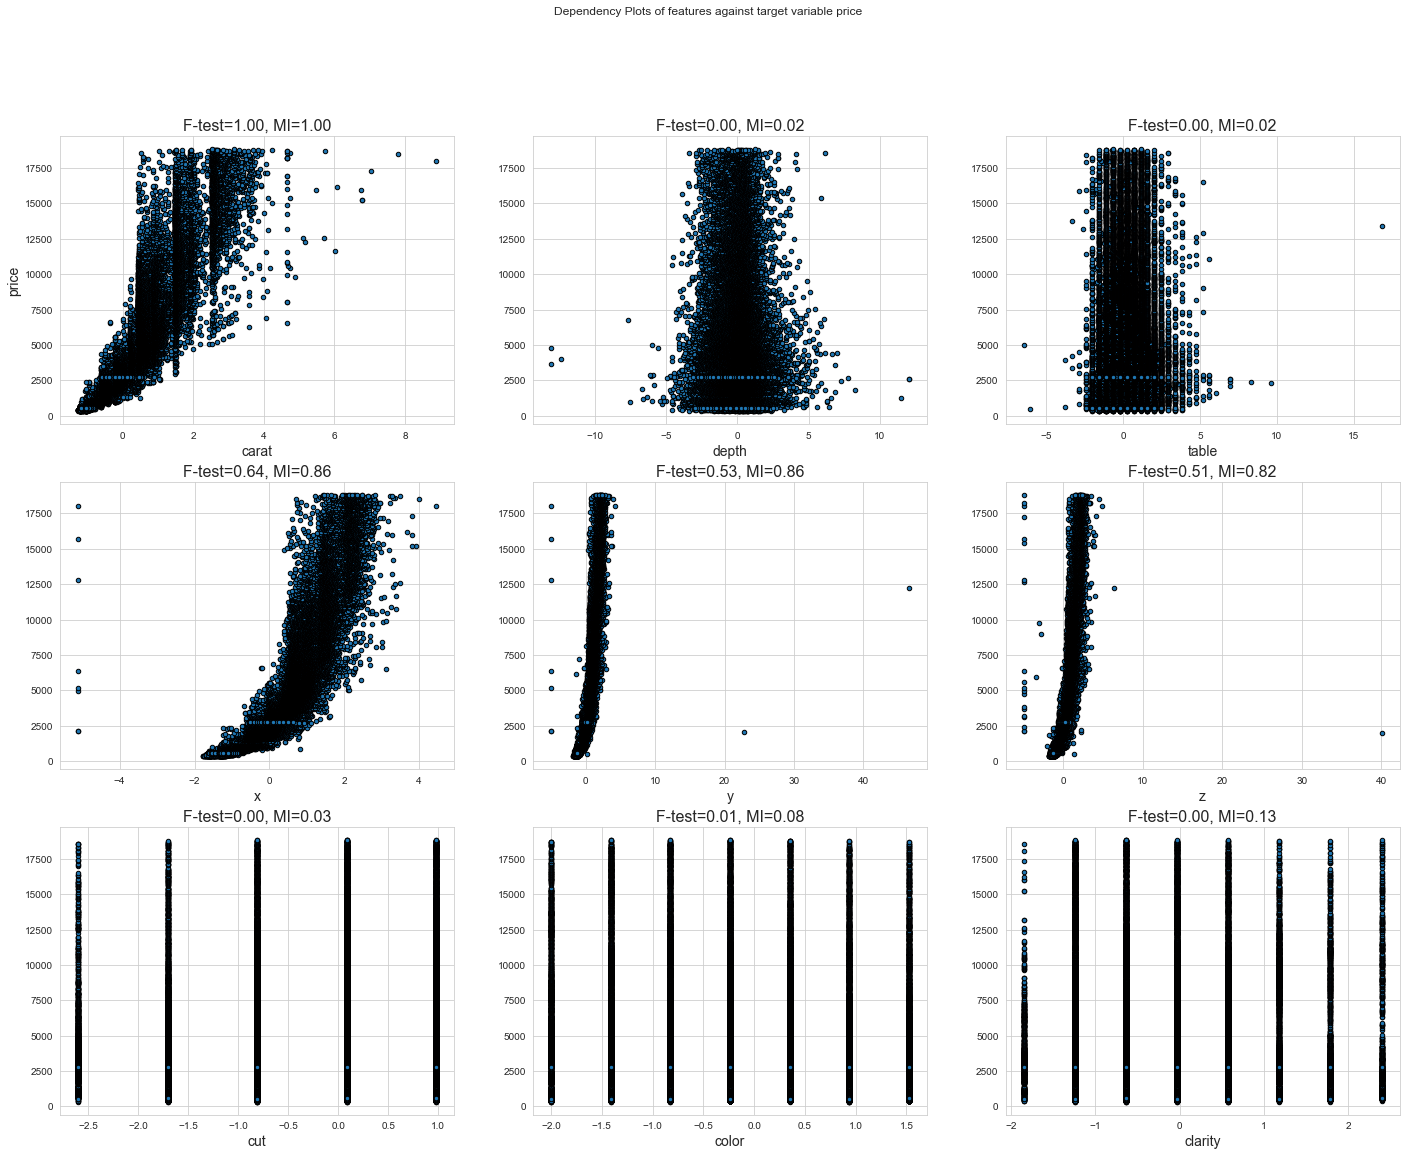

In [54]:
target_name ='price'
plt.figure(figsize=(24, 18))
plt.suptitle(f'Dependency Plots of features against target variable {target_name}')
for i, feat in enumerate(diamond_features):
    plt.subplot(3, 3, i + 1)
    plt.scatter(X_diamonds[feat], y_diamonds, edgecolor="black", s=20)
    plt.xlabel(feat, fontsize=14)
    if i == 0:
        plt.ylabel(target_name, fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(res_df['F Regression Score - Scaled'].iloc[i], res_df['Mutual Info Regression Score - Scaled'].iloc[i]), fontsize=16)
plt.show()

__Diamonds Data Most important Features:__

Mutual Info Regression most important 4 features:  carat, y, x, z.
F Regression most important 4 features: carat, x, y, z.

The order between mutual info and f regression for feature importances are slightly different.

I also experimented on different feature sets with Linear Regression model to see how their performance would change. All features in the diamond dataset seems to be helping for prediction since subset of the features perform worse with Linear Regression model. Given that diamonds dataset has very few variables, I decided to keep all of them and skip the feature selection part.

In [82]:
def apply_cv_to_model(model, X, y, model_name, cv=10, scoring= 'neg_root_mean_squared_error', print_res=True):
    cv_results = cross_validate(model, X,y,
                                    scoring=scoring, cv=cv, 
                                    return_train_score=True,return_estimator=True)
    train_rmse = cv_results['train_score']*(-1.)
    test_rmse = cv_results['test_score']*(-1.)
    if print_res:
        print(f'{model_name} Train Avg RMSE accross 10-fold cv: ', train_rmse.mean())
        print(f'{model_name} Validation Avg RMSE accross 10-fold cv: ',test_rmse.mean())
    return cv_results 

In [83]:
feat_sets = [ ('All Features', X_diamonds.columns.tolist()),
             ('Top 6 Features', ['carat','x','y','z','clarity','color']),
             ('Top 4 Features', ['carat','x','y','z'])
]

for f_name, feat_set in feat_sets:
    print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
    model_lr = LinearRegression()
    important_feats_diamonds = ['carat','x','y','z','clarity','color']
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_diamonds[feat_set], y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)

for name, fs in [('Mutual Info Regr.',mutual_info_regression),  ('F Regr.',f_regression)]:
    top_feats = 5
    print(f'\n\nTop {top_feats} {name} features:')
    X_new = SelectKBest(fs, k=top_feats).fit_transform(X_diamonds, y_diamonds)

    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_new, y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)



10-fold CV Linear Regression Experiment with All Features: 
 Features:['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


10-fold CV Linear Regression Experiment with Top 6 Features: 
 Features:['carat', 'x', 'y', 'z', 'clarity', 'color']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1221.6042206336504
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1228.2203041711414


10-fold CV Linear Regression Experiment with Top 4 Features: 
 Features:['carat', 'x', 'y', 'z']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1512.5608891324323
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1405.0166387786403


Top 5 Mutual Info Regr. features:
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1327.377219542444
Linear Regression (OLS) Validation Avg 

__Gas Data Mutual Info Regression & F Regression__

TODO answer question

__Gas Data Most important Features:__




__How does this step affect the performance of your models in terms of test RMSE?__

Feature selection has different effects on the performance of the test data. If the removed features contains redundant data, noise or unrelated to the target variable, this step reduces the chances for overfitting, enhance the model generalization and improves the test RMSE score. This means if features selected precisely, test RMSE score is expected to lower and model to perform better. However, if deleted features contain important information that can be used for the prediction, the test RMSE score would increase and model performing worse. That is why, feature selection is a not a trivial step and should be performed carefully on which data we want to keep and remove. Feature selection also help decreasing both training and inference time given that we have to deal with less data. 

If we think specifically for feature selection based on mutual information, it is not only limited to linear dependency but it rather quantifies the amount of information obtained from observing one variable about the other one. Whereas f regression captures only linear relationship between variables. Ideally, both feature selection methods expect to decrease redundant variables which leads less opportunity to overfit the model and better generalization. This means we expect to have good performing models with lower RMSE test scores. However, again we need to be careful, for example, with f regression we might possibly discard important nonlinear features during feature selection. This might hurt the model performance and increase the test RMSE score.
To conclude, feature selection is a step to help reducing overfitting and to have generalization, improving both performance and time to train and inference of the model and leads to lower test RMSE score if performed successfully.




## Linear Regression

#### Question 8

__What is the objective function?__

The Linear Regression model prediction is made:
$$ \hat{y} = b + \sum_{i=1}^{p} x_iw_i =  x^Tw $$

$\hat{y}$ is predicted value, b bias (intercept term), p is the number for features, w is weights and x is the input data.
(In the second part of the equation b is incorparated in the w in this case.).

Using RMSE as our error metric:

__Ordinary Least Squares (Linear Regression without Regularization) Objective Function:__

$ \min_{w} ||(Xw - Y)||^2_2 $

__Lasso Regression (L1 Regularization) Objective Function:__

$ \min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||_1$


__Ridge Regression (L2 Regularization) Objective Function:__

$\min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||^2_2$

X input, Y ground truth label, w parameters and $\lambda$ is the regularization strength, hyperparameter to be tuned.

__Explain how each regularization scheme affects the learned hypotheses.__ 

Regularization techniques are used to avoid model overfitting and improving model generalization by adding a penalty term to the objective function. The intuition behind regularization is that by adding penalty terms related to the model weights (coefficients), the optimizer won't try to increase some weights larger and larger, so it encourages the weights to be kept small.

- __Lasso Regression:__

Lasso is also called L1 Regularization, it adds the absolute value of magnitude of coefficients  (L1 norm) as penalty term to the loss function. It's advantage is it can set some coefficients to 0 (create sparse solutions), hence it might eliminate some features and can be considered as a built-in feature selection. It has unstable solution and may have  multiple solutions for the optimization problem. 


- __Ridge Regression:__

Ridge also called as L2 regularization since it adds squared magnitude of coefficients (squared L2 norm) as penalty term to the loss function. It forces the coefficients to be lower, close to 0 but not 0. The output is therefore non-sparse and it doesn't choose some subset of the features. It is computationally efficient since it has analytical solutions. After L2 regularization the optimal solutions are generally more stable.


#### Question 9

For each model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

__How to pick optimal penalty (lambda) parameter? (alpha in sklearn)__

There are several ways to select best values for choosing optimal regaularization value for linear models:

1- Via cross validation and grid search    
2- Using information criterion (AIC, BIC) for Lasso Regression     
3- Using model specific cross validations implemented in sklearn such as LassoCV and RidgeCV.   

Lasso and Ridge models also have their own special cross validation implementations in scikit-learn to find a good value of penalty scores. They are called LassoCV and RidgeCV model, but the scores are calculated in terms of MSE rather than RMSE and only test scores are returned. Given that we are also interested on the training scores for the questions, I could't use these functions. 

For Lasso Regression you can see the results of different lambda (alpha in sklearn) parameters both with Cross Validation + GridSearch and with AIC, BIC method. For Ridge Regression alpha value is only done with 10-fold cross validation over gridsearch with different lambda (alpha in sklearn) values.

Note: For cross validation results, sklearn scoring function uses negative RMSE values (neg_root_mean_squared_error) to be able to minimize the loss function. That is why the returned RMSE values are negative and we can simply get their absolute results as the RMSE value.

##### __Ordinary Least Squares (Linear Regression without Regularization)__

In [84]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


Check RMSE results for each of the 10-fold:

In [85]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


##### __Lasso Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [91]:
def linear_model_exp(X,y):
    full_pipeline = Pipeline([('model', "passthrough")
                             ])
    alphas = [10**(x) for x in range(-8,6)]
    params = {
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)
               ],
        "model__alpha": alphas
    }

    t0 = time.time()
    grid_search = GridSearchCV(full_pipeline, params, cv=10, 
                               scoring='neg_root_mean_squared_error', 
                               return_train_score=True)
    cv_results = grid_search.fit(X, y)
    t1 = time.time()
    elapsed = t1-t0
    #print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
    grid_results_df = pd.DataFrame(grid_search.cv_results_)
    grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')
    grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
    grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
    grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
    #grid_results_df.head()
    return grid_search, grid_results_df

In [93]:
grid_search_lr, grid_res_lr_df = linear_model_exp(X=X_diamonds, y=y_diamonds)

In [94]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df[grid_res_lr_df.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045052      Lasso              1e-06
17       1206.280597            1205.045064      Lasso              1e-05
18       1206.280597            1205.045161      Lasso             0.0001
19       1206.280597            1205.046257      Lasso              0.001
20       1206.280605            1205.057629      Lasso               0.01
21       1206.281434            1205.175550      Lasso                0.1
22       1206.357387            1206.498138      Lasso                  1
23       1210.657916            1225.290602      Lasso                 10
24       1251.275772            1244.896044      Lasso                100
25       1843.911711            1770.022846      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

The best average train and validation RMSE scores for Lasso Regression are in the 1205-1206 ranges. A good range for alpha is in this case is around 0.01 and 1. Since the RMSE doesn't change too much, we can pick 1 as the optimal penalty parameter. The reason behind is that we want to have simpler model that could achieve a good performance. Having a higher regularization helps us having simpler model and we can see that with $\alpha=1$ we can achieve average RMSE results very close to the ones we found in the case of no regularization both in training and validation sets.   

##### __Penalty Selection based on AIC/BIC__

Lasso model fit with Lars using BIC (Bayes Information criterion) or AIC (Akaike information criterion) for model selection. 
These two criterion are used to select the regularization parameter. A good model should explain well the data while being simple to achieve that a trade-off between the goodness of fit and the complexity of the model is made.

In [96]:
lasso_lars_ic =  LassoLarsIC(criterion="aic", normalize=False).fit(X=X_diamonds, y=y_diamonds)
results = pd.DataFrame({"alphas": lasso_lars_ic.alphas_,
                        "AIC criterion": lasso_lars_ic.criterion_,}).set_index("alphas")
alpha_aic = lasso_lars_ic.alpha_
lasso_lars_ic.set_params(criterion="bic").fit(X_diamonds, y_diamonds)
results["BIC criterion"] = lasso_lars_ic.criterion_
alpha_bic = lasso_lars_ic.alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

In [37]:
def plot_aic_bic(alpha_aic, alpha_bic, results):
    ax = results.plot(figsize=(8,7))
    ax.vlines(
        alpha_aic,
        results["AIC criterion"].min(),
        results["AIC criterion"].max(),
        label="alpha: AIC estimate",
        linestyles="--",
        color="tab:blue",
    )
    ax.vlines(
        alpha_bic,
        results["BIC criterion"].min(),
        results["BIC criterion"].max(),
        label="alpha: BIC estimate",
        linestyle="--",
        color="tab:orange",
    )
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("criterion")
    ax.set_xscale("log")
    ax.legend()
    _ = ax.set_title(
        f"Information-criterion for model selection)"
    )

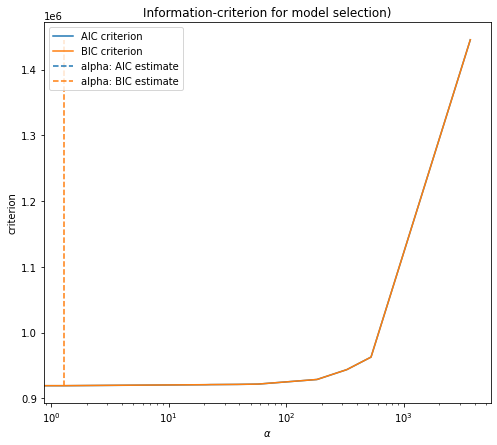

In [38]:
plot_aic_bic(alpha_aic=alpha_aic, alpha_bic=alpha_bic, results=results)

According to AIC criterion good alpha value is 0, and BIC criterion is around 1.3. This also supports the result we found above.

##### __Ridge Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [97]:
grid_res_lr_df[grid_res_lr_df.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045052      Ridge              1e-05
4        1206.280597            1205.045059      Ridge             0.0001
5        1206.280597            1205.045137      Ridge              0.001
6        1206.280597            1205.045909      Ridge               0.01
7        1206.280598            1205.053637      Ridge                0.1
8        1206.280754            1205.131037      Ridge                  1
9        1206.295931            1205.916546      Ridge                 10
10       1207.536689            1214.414691      Ridge                100
11       1248.699264            1292.818122      Ridge               1000
12       1458.983908            1489.476610      Ridge              10000
13       2112.850610            1950.711595      Ridge             100000

In the case of Rigde regression we can increase the regularization in the range of 1-10. With the similar reasoning explained for Lasso, I will pick 10 as the optimal parameter. 

##### __Best Regularization with optimal penalty parameter__

In the diamonds dataset, both Lasso and Ridge Regularization reach the same optimal results for average RMSE on training and validation sets. These results are also same for Linear Regression without regularization and lies in within 1205-1206 RMSE score. If we only look at the average optimal results, these 3 models don't really have much difference. When I checked the std of the train and validation RMSE scores for 10-fold cv(shown below) and the scores for each fold individually, again there is nothing very different for Lasso and Ridge Regression.

If I choose one, I would pick Ridge regularization since it seems to be better regularization scheme for diamonds data for the overall RMSE scores for higher regularization values. The avg. scores are way lower in Ridge then Lasso. For example Lasso when alpha=1000 avg RMSE validation score=1770 and Ridge when alpha=1000 avg RMSE validation score=1292. Therefore, Ridge regularization is best regularization scheme with optimal penalty 1.

Ridge Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [108]:
model = 'Ridge'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
8        -943.047423        -918.745592       -1112.593318       -1480.207682   
9        -945.772298        -921.113590       -1112.713075       -1476.998752   

   split4_test_score  split5_test_score  split6_test_score  split7_test_score  \
8       -2806.756166       -1700.057234        -815.570266        -877.496956   
9       -2809.011538       -1702.738090        -814.432034        -876.470311   

   split8_test_score  split9_test_score  mean_validation_score  \
8        -670.987363        -725.848366            1205.131037   
9        -672.135127        -727.780644            1205.916546   

   std_test_score  rank_test_score  
8      617.997804               16  
9      618.307116               18

split0_train_score  split1_train_score  split2_train_score  \
8        -1246.677053        -1248.662286        -1230.784516   
9        -1246.688078        -1248.673713        -1230.798464   

   split3_train_score  split4_train_score  split5_train_score  \
8        -1190.650864         -954.234736        -1157.681538   
9        -1190.668558         -954.268267        -1157.694613   

   split6_train_score  split7_train_score  split8_train_score  \
8        -1256.252739        -1252.998340        -1264.052939   
9        -1256.266196        -1253.011377        -1264.065238   

   split9_train_score  mean_train_score  std_train_score  
8        -1260.812526       1206.280754        90.084923  
9        -1260.824805       1206.295931        90.078895

Lasso Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [109]:
model = 'Lasso'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  \
22        -948.420031        -923.845640       -1113.481926   
23       -1001.156908        -974.532777       -1125.583926   

    split3_test_score  split4_test_score  split5_test_score  \
22       -1476.159596       -2810.451532       -1705.121582   
23       -1436.060043       -2869.030266       -1761.357107   

    split6_test_score  split7_test_score  split8_test_score  \
22        -812.459728        -874.713354        -671.818620   
23        -788.742713        -848.425307        -684.250555   

    split9_test_score  mean_validation_score  std_test_score  rank_test_score  
22        -728.509373            1206.498138      618.777888               19  
23        -763.766418            1225.290602      632.064742               21

split0_train_score  split1_train_score  split2_train_score  \
22        -1246.742106        -1248.726980        -1230.852788   
23        -1250.603468        -1252.591315        -1234.881322   

    split3_train_score  split4_train_score  split5_train_score  \
22        -1190.696045         -954.420070        -1157.758913   
23        -1194.615517         -961.823509        -1162.617515   

    split6_train_score  split7_train_score  split8_train_score  \
22        -1256.316502        -1253.061068        -1264.115736   
23        -1260.161182        -1256.757931        -1267.712219   

    split9_train_score  mean_train_score  std_train_score  
22        -1260.883657       1206.357387        90.051053  
23        -1264.815178       1210.657916        88.987987

In [ ]:
# TODO experiment with different categorical encoding.

#### Question 10

The same experiments as Q9 applied on unscaled features.

#### __Diamond Dataset__

##### __Not scaled Feature results__

In [119]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds_unscaled, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)')

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.2805967946167
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850984


Check RMSE results for each of the 10-fold:

In [120]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


In [113]:
grid_search_lr_unscl, grid_res_lr_df_unscl = linear_model_exp(X=X_diamonds_unscaled, y=y_diamonds)

In [115]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045053      Lasso              1e-06
17       1206.280597            1205.045073      Lasso              1e-05
18       1206.280597            1205.045263      Lasso             0.0001
19       1206.280597            1205.047165      Lasso              0.001
20       1206.280609            1205.066857      Lasso               0.01
21       1206.281892            1205.272222      Lasso                0.1
22       1206.403372            1207.533286      Lasso                  1
23       1215.137979            1238.590955      Lasso                 10
24       1362.777782            1459.776195      Lasso                100
25       2049.825908            1984.620077      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

In [116]:
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045055      Ridge              1e-05
4        1206.280597            1205.045088      Ridge             0.0001
5        1206.280597            1205.045421      Ridge              0.001
6        1206.280597            1205.048757      Ridge               0.01
7        1206.280619            1205.082125      Ridge                0.1
8        1206.282816            1205.417296      Ridge                  1
9        1206.492542            1208.905905      Ridge                 10
10       1220.380991            1249.715537      Ridge                100
11       1388.872280            1472.734228      Ridge               1000
12       1597.964835            1620.737422      Ridge              10000
13       2266.684099            2074.013462      Ridge             100000

__Does feature scaling play any role (in the cases with and without regularization)?__

For diamonds data, Ridge Regression on scaled data has lower average RMSE values for the alpha > 10 compared the same lambda values applied on unscaled data on Ridge. For Lasso, we see that for larger alpha values, we see the same trend, scaled data has either lower or very similar value compared the unscaled data. 
The trends are same both in train and validation sets. This experiment shows that scaling our data is a good technique, which helps us getting better avg. RMSE scores especially against higher penalty regularization parameter values (seen from above tables). It is also important to note that the best/optimal avg. RMSE values found for scaled and unscaled data are almost same for optimal Ridge and optimal Lasso alpha values lying in the 1205-1206 range. For the unscaled data, the optimal value for regularization parameters are smaller, for Ridge optimal alpha is 1 and for Lasso alpha is 0.1.

From the experiments on diamonds data above, scaling data doesn't seem to play a role on the case without regularization.
For the regularization on the other hand, scaling improves the avg. RMSE scores across different lambda values. This means for unscaled data the choice of regularization parameter is more crucial since the RMSE results can explode and grow very quickly when the data is unscaled and an unoptimal lambda parameter is chosen. 



#### Question 11

__Some linear regression packages return p-values for different features. What is the meaning of them and how can you infer the most significant features?__


P-values for each feature tests a null hypothesis that the coefficient has no effect (equal to 0). A typical threshold for p-value is 0.05 (corresponds to 95% confidence interval. A p-value lower than threshold ( < 0.05) means we should reject the null hypothesis and the feature is important for the prediction of the target variable. A p-value higher than threshold, means that the feature is statistically not significant to predict the target variable, the change in target variable is not associated with the feature. The p-values can be used to find most meaningful feature and may be used to decide which features to keep in the model and which ones we can remove.

scipy.stats.linregress and statsmodels.regression.linear_model.OLS are two library models that returns p-values for each feature where we can infer most significant features using them. I experimented with statsmodels.regression.linear_model.OLS on diamonds dataset to find important features for scaled and unscaled dataset:

__Diamonds Data Scaled (statsmodels.regression.linear_model.OLS) Results__

In [132]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)

OLS params: 
 carat      5092.655074
depth      -114.319163
table       -59.802654
x          -984.480857
y            49.963989
z           -20.679798
cut         134.816544
color       548.941110
clarity     826.612634
dtype: float64


These are the coefficients assigned to each feature. The highest coefficient is given to carat meaning carat has the highest positive impact on the diamond price. Whereas x has the largest negative coefficient which means x also has a high impact, this time inverse relation, on the diamond price: lower the x the higher price we can assign.

__OLS Summary for Scaled Diamonds Data:__

In [134]:
print(ols_stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              5100.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:53:32   Log-Likelihood:                     -5.2549e+05
No. Observations:               53940   AIC:                                  1.051e+06
Df Residuals:                   53931   BIC:                                  1.051e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By looking the p-values in the above table (P >|t|), we can see that carat, depth, x, cut, color, clarity values have p-values lower than 0.05 and are the most important features. The R^2 and adjusted R^2 values for the model is 0.46 which is pretty low. 

__Diamonds Data Unscaled (statsmodels.regression.linear_model.OLS) Results__

When we used unscaled data to apply OLS the R^2 and adjusted R^2 results are very high, 0.953 with all the diamonds features. Also all the features have p-values lower than 0.05. This means that with unscaled features OLS can fit a good linear model where all features are important for the prediction.

In [140]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds_unscaled)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)
print(ols_stats_model_results.summary())

OLS params: 
 carat      10587.758498
depth        -41.693458
table         -8.901253
x           -770.488938
y             60.599056
z           -121.711175
cut          144.798827
color        324.416568
clarity      506.522714
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.210e+05
Date:                Thu, 03 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:58:38   Log-Likelihood:                     -4.5975e+05
No. Observations:               53940   AIC:                                  9.195e+05
Df Residuals:                   53931   BIC:                                  9.196e+05
Df Model:                           9              

## Polynomial Regression

#### Question 12

For each polynomial regression model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

For this experiment, I created a pipeline to extract polynomial features with PolynomialFeatures() in sklearn and applied Linear Regression on the compound features (I used Lasso and Ridge Regression models for regularization). Grid search over 10-fold cv is applied to tune degrees for polynomial features and alpha for the regularization. Degree range is [2,4] and alpha range is $[10^{-4}, 10^3]$. 

In [345]:
def model_experiment(X, y, full_pipeline, params, fname, model_file, cv, rerun, search_type='grid', n_iter=10, scoring='neg_root_mean_squared_error', verbose=0):
    if os.path.isfile(fname) and (not rerun):
        grid_results_df = pd.read_csv(fname)
        #load your model for further usage
        grid_search = joblib.load(model_file)
        return grid_search, grid_results_df
    else:
        t0 = time.time()
        if scoring == 'neg_root_mean_squared_error':
            refit=True
        else:
            refit='RMSE'
        
        if search_type=='randomized':
            grid_search = RandomizedSearchCV(full_pipeline, param_distributions=params, 
                                     n_iter=n_iter, 
                                     cv=cv,
                                     scoring=scoring,
                                     refit=refit,
                                     return_train_score=True,
                                     verbose=verbose)
    
        else: # do grid search
            grid_search = GridSearchCV(full_pipeline, params, cv=cv, 
                                       scoring=scoring, 
                                       refit=refit,
                                       return_train_score=True,
                                       verbose=verbose)
            
        cv_results = grid_search.fit(X, y)
        t1 = time.time()
        elapsed = t1-t0
        print('Time for experiment:',time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
        grid_results_df = pd.DataFrame(grid_search.cv_results_)
        if scoring == 'neg_root_mean_squared_error':
            grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
            grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
            grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
        grid_results_df.to_csv(fname)
        #save your model or results
        joblib.dump(grid_search, model_file)
        #grid_results_df.head()
        return grid_search, grid_results_df
        
def polynomial_feat_linear_model_exp(X,y, data_name, search_type, interaction_only='False', cv=10, n_iter=10, rerun=False, post_fix=''):
    fname = f'exp_results/{data_name}_polynomial_feat_linear_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_polynomial_feat_linear_model{post_fix}.pkl'

    full_pipeline = Pipeline([('poly_features', "passthrough"),
                             ('model', "passthrough")
                    ])
    alphas = [10**(x) for x in range(-4,4)]
    degrees = [2,3,4]
    params = {
        "poly_features": [PolynomialFeatures(interaction_only=interaction_only)],
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)],
        "poly_features__degree":degrees,
        "model__alpha": alphas
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter)
    #grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')

    return grid_search, grid_results_df

In [268]:
 grid_search_poly, grid_res_poly_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', search_type='grid')
    
    

Time for experiment: 00h54m37s


##### __Polynomial Regression Experiment Results__

In [269]:
show_cols =['mean_train_score','mean_validation_score','param_model','param_model__alpha','param_poly_features__degree']
grid_res_poly_df[show_cols]

mean_train_score  mean_validation_score  \
0         755.238322           1.905579e+03   
1         595.202266           1.023723e+05   
2         544.154516           1.441024e+07   
3         755.238322           1.905577e+03   
4         595.211933           9.596343e+04   
5         544.863716           9.133460e+06   
6         755.238330           1.905561e+03   
7         595.273934           7.892820e+04   
8         546.351569           4.116663e+06   
9         755.239061           1.905460e+03   
10        595.632247           4.820964e+04   
11        548.825172           1.132145e+06   
12        755.288556           1.907972e+03   
13        596.875236           2.097185e+04   
14        552.145351           2.806880e+05   
15        756.657944           1.948870e+03   
16        600.449375           3.658403e+03   
17        556.552364           1.266973e+05   
18        770.320676           1.967880e+03   
19        607.725528           2.906748e+03   
20        564.089533           7.353184e+04   
21        795.955216           1.667222e+03   
22        627.152892           5.991348e+03   
23        583.572956           7.188001e+04   
24        757.769711           1.777435e+03   
25        605.139821           9.765500e+03   
26        570.306030           3.348265e+04   
27        757.769829           1.777749e+03   
28        605.140763           9.763747e+03   
29        570.307198           3.339771e+04   
30        757.771652           1.780883e+03   
31        605.152051           9.758096e+03   
32        570.322677           3.252668e+04   
33        757.857294           1.809239e+03   
34        605.419862           9.841995e+03   
35        570.778600           2.553300e+04   
36        763.272005           1.615358e+03   
37        609.616162           7.549581e+03   
38        576.546114           1.212026e+04   
39        782.419320           1.129773e+03   
40        638.349676           3.514891e+03   
41        602.482754           3.096670e+04   
42        921.572213           8.822264e+02   
43        858.951808           3.411950e+03   
44        847.514766           1.482473e+04   
45       1841.870944           1.790713e+03   
46       2023.787034           1.902184e+03   
47       2000.160844           4.410692e+03   

                           param_model param_model__alpha  \
0              Ridge(random_state=142)             0.0001   
1              Ridge(random_state=142)             0.0001   
2              Ridge(random_state=142)             0.0001   
3              Ridge(random_state=142)              0.001   
4              Ridge(random_state=142)              0.001   
5              Ridge(random_state=142)              0.001   
6              Ridge(random_state=142)               0.01   
7              Ridge(random_state=142)               0.01   
8              Ridge(random_state=142)               0.01   
9              Ridge(random_state=142)                0.1   
10             Ridge(random_state=142)                0.1   
11             Ridge(random_state=142)                0.1   
12             Ridge(random_state=142)                  1   
13             Ridge(random_state=142)                  1   
14             Ridge(random_state=142)                  1   
15             Ridge(random_state=142)                 10   
16             Ridge(random_state=142)                 10   
17             Ridge(random_state=142)                 10   
18             Ridge(random_state=142)                100   
19             Ridge(random_state=142)                100   
20             Ridge(random_state=142)                100   
21             Ridge(random_state=142)               1000   
22             Ridge(random_state=142)               1000   
23             Ridge(random_state=142)               1000   
24  Lasso(alpha=100, random_state=142)             0.0001   
25  Lasso(alpha=100, random_state=142)             0.0001   
26  Lasso(alpha=100, random_state=142)             0.

__Best model found from GridSearch:__

In [270]:
best_model_poly = grid_search_poly.best_estimator_
best_model_poly

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('model', Lasso(alpha=100, random_state=142))])

In [271]:
grid_search_poly.best_params_

{'model': Lasso(alpha=100, random_state=142),
 'model__alpha': 100,
 'poly_features': PolynomialFeatures(),
 'poly_features__degree': 2}

__Coefficient of the best model:__

In [272]:
best_model_poly = grid_search_poly.best_estimator_
feature_names = best_model_poly['poly_features'].get_feature_names_out()

coefs_df = pd.DataFrame(
    best_model_poly['model'].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs_df

Coefficients
1                  0.000000
carat           3819.165766
depth             -0.000000
table             -0.000000
x                  0.000000
y                  0.000000
z                  0.000000
cut               19.424984
color            379.512189
clarity          736.942242
carat^2            0.000000
carat depth       -0.000000
carat table       -0.000000
carat x          255.502250
carat y            0.000000
carat z            0.000000
carat cut         36.487862
carat color      340.220949
carat clarity    658.568956
depth^2          -25.612413
depth table        0.000000
depth x           -0.000000
depth y           -0.000000
depth z           -0.000000
depth cut          0.000000
depth color        0.000000
depth clarity      0.000000
table^2           -0.000000
table x           -0.000000
table y           -0.000000
table z           -0.000000
table cut          0.000000
table color        0.000000
table clarity      0.000000
x^2              272.697483
x y               83.223653
x z                0.000000
x cut              0.000000
x color            0.000000
x clarity          0.000000
y^2               -0.961110
y z                0.000000
y cut              0.000000
y color            0.000000
y clarity          0.000000
z^2                0.000000
z cut              0.000000
z color            0.000000
z clarity          0.000000
cut^2             -5.943162
cut color         -0.000000
cut clarity       -0.000000
color^2          -58.635986
color clarity     79.471302
clarity^2         -0.000000

Lasso Regression assigns also 0 values to coefficients as seen above, to understand salient features better, I plotted the non-zero coefficients.

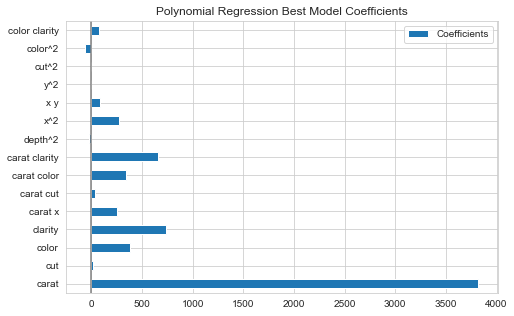

In [273]:
coefs_df[coefs_df.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest value:

In [274]:
coefs_df[coefs_df.Coefficients!=0].sort_values(by='Coefficients', ascending=False).T

carat     clarity  carat clarity       color  carat color  \
Coefficients  3819.165766  736.942242     658.568956  379.512189   340.220949   

                     x^2    carat x        x y  color clarity  carat cut  \
Coefficients  272.697483  255.50225  83.223653      79.471302  36.487862   

                    cut      y^2     cut^2    depth^2    color^2  
Coefficients  19.424984 -0.96111 -5.943162 -25.612413 -58.635986

From the coefficients, we can see that Lasso assigns 0 to many of the features and only small number of them have non-zero coefficients.
Within the most salient features, the most important one is carat with the biggest coefficient 3819.17. This means 



#### Question 13

The experiment is done for degrees 2, 3, and 4. Given that degree=1 would be just linear results, and we want to see the results for polynomial features, I omitted degree=1 in the experiment. I also didn't include degrees higher than 4 because given the dataset, the amount of compound features created would be too much with degrees higher than 5. Another reason is that both dataset are relatively small 30-50k samples, very high degrees would more likely to cause overfit rather then help generalizing the model.  

__What degree of polynomial is best?__
From experiment results we can see that the best degree is 2. The first 9 of the top 10 combinations of our experiment shows that 2 is the best degree values anf Lasso is a better regularization for this dataset.

Best model parameters:

In [275]:
grid_search_poly.best_params_

{'model': Lasso(alpha=100, random_state=142),
 'model__alpha': 100,
 'poly_features': PolynomialFeatures(),
 'poly_features__degree': 2}

Top 10 combinations from gridsearch results sorted with lowest RMSE validation scores:

In [277]:
grid_res_poly_df[show_cols].sort_values(by='mean_validation_score', ascending=True).head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model param_model__alpha  \
42  Lasso(alpha=100, random_state=142)                100   
39  Lasso(alpha=100, random_state=142)                 10   
36  Lasso(alpha=100, random_state=142)                  1   
21             Ridge(random_state=142)               1000   
24  Lasso(alpha=100, random_state=142)             0.0001   
27  Lasso(alpha=100, random_state=142)              0.001   
30  Lasso(alpha=100, random_state=142)               0.01   
45  Lasso(alpha=100, random_state=142)               1000   
33  Lasso(alpha=100, random_state=142)                0.1   
46  Lasso(alpha=100, random_state=142)               1000   

   param_poly_features__degree  
42                           2  
39                           2  
36                           2  
21                           2  
24                           2  
27                           2  
30                           2  
45                           2  
33                           2  
46                           3

__What does a very high-order polynomial imply about the fit on the training data? How do you choose this parameter?__

With a higher-order polynomial, we can create more complex models that covers larger hypothesis spaces. With increasing model complexity, it means we can fit the data better, however, if the degree of polynomial is higher than the optimal degree that data lies, then model may overfit the data. In case of overfitting, the fitted curve will start to memorize the training data rather then learn to generalize and find patterns. When model overfits, the training error would be low and test/validation errors would be high since it perform badly on the unseen data. We can see this from the experiment results in the above table as well. For higher degrees we see that training errors (avg RMSEs) are very low but the avg. validation scores are very high compared to the training score. 

On the other hand, if the degree order is too small, the model cannot learn enough from the data and model can underfit resulting in high training and validation errors. 
In order to avoid overfitting or underfitting, and have a model that generalizes well, we need to choose a degree that matches with the true structure of the data. This happens when the the model has a good training score and the gap between the training and validation scores are lowest. One way to choosee optimal degree parameter, is to run cross validation with different degree values and compare the avg. training and validation results. Then choose a degree where model has low trainining RMSE and low test RMSE. The optimal point is generally when the model has low training RMSE and the gap beetween train and validation score is also lowest.

#### Question 14

__For the diamond dataset it might make sense to craft new features such as z = x1 × x2, etc. Explain why this might make sense and check if doing so will boost accuracy.__

Depending on some dataset a compound feature might make sense on predicting the target variable. For example, for the diamonds dataset the diamond price might be correlated with the diamond volume, and diamond volume can be represented by x*y*z. Using compounding features (combination of different features) might be more helpful in predicting target variable rather than individual columns by itself. There could be cases where individual feature might not contribute as much as a compound feature to the prediction. 

I tried 2 approaches to craft new features such as z= x1 x x2. 

Approach 1: Use interaction_only=True in Polynomial Features and run only for the combinations of different features. In this approach I created all possible interacted features and checked whether any of them are important features. 

Approach 2: Create craft features by hand for the combinations that makes sense and could be helpful for prediction of target variable:

For diamonds dataset new hand crafted features:

    - volume of diamond: x * y * z
    - table * depth
    - density of diamond: carat / x*y*z


__Approach 1: Polynomial Feature on Interactions only__

I applied a randomized search with 12 samples (n_iter) with the same parameter range on q12, but this time I only used the compound features to feed in the linear model. I did 10-fold cv and Lasso, Ridge Regularizations.

In [290]:
pf = PolynomialFeatures(interaction_only=True, degree=2)
X_diamonds_inter_only = pf.fit_transform(X_diamonds, y_diamonds)

model_lr_q14 = Lasso(alpha=100, random_state=rand_seed) #LinearRegression()
cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                  X=X_diamonds_inter_only, y=y_diamonds, 
                                  model_name='Linear Regression (OLS) with new features')

Linear Regression (OLS) with new features Train Avg RMSE accross 10-fold cv:  927.3097101114097
Linear Regression (OLS) with new features Validation Avg RMSE accross 10-fold cv:  873.1990244523037


In [294]:
cv_results_lr_q14

{'fit_time': array([0.13242102, 0.1089139 , 0.13755274, 0.10711002, 0.18514514,
        0.12762189, 0.10351992, 0.12981892, 0.11299038, 0.16034293]),
 'score_time': array([0.000736  , 0.00086617, 0.00082207, 0.00085711, 0.00095677,
        0.00082827, 0.00087619, 0.00084901, 0.00069475, 0.00091219]),
 'estimator': [Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142),
  Lasso(alpha=100, random_state=142)],
 'test_score': array([ -638.48921931,  -638.73323239,  -842.91277409, -1197.92277749,
        -2821.42759997, -1393.0967988 ,  -209.22439728,  -224.87860465,
         -283.79150864,  -481.51333191]),
 'train_score': array([-942.13687636, -943.06672942, -927.64248374, -909.64281756,
        -837.66771612

In [291]:
feature_names_inter = pf.get_feature_names_out()

coefs_df_inter = pd.DataFrame(
    model_lr_q14.coef_,
    columns=["Coefficients"],
    index=feature_names_inter,
)
coefs_df_inter

AttributeError: 'Lasso' object has no attribute 'coef_'

In [308]:
grid_search_poly_interaction_only, grid_res_poly_inter_only_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', interaction_only=True,
                                                                       search_type='grid', rerun=False,
                                                                       post_fix='interaction_only')
    
    

Time for experiment: 00h20m03s


In [309]:
grid_res_poly_inter_only_df[show_cols]

mean_train_score  mean_validation_score  \
0         779.054070            1691.673760   
1         640.554800            2182.187548   
2         616.777844            5431.125509   
3         779.054070            1691.657351   
4         640.554801            2182.841480   
5         616.778008            5382.117438   
6         779.054071            1691.493295   
7         640.554949            2189.270755   
8         616.788982            4978.117484   
9         779.054212            1689.856625   
10        640.566311            2244.427351   
11        616.981021            3679.660710   
12        779.067556            1673.866997   
13        640.881098            2455.346943   
14        617.739432            3429.110911   
15        779.918070            1543.557886   
16        643.749498            2399.515225   
17        619.759018            3186.904741   
18        789.987240            1108.538274   
19        658.978802            1713.443479   
20        627.378494            2291.420257   
21        811.508988             874.116912   
22        683.784705            1067.001516   
23        647.120971            1101.171040   
24        781.844344            1563.982397   
25        650.075923            2385.962268   
26        625.996292            2582.356901   
27        781.846754            1563.536512   
28        650.077536            2384.769894   
29        625.996702            2582.064990   
30        781.871658            1559.078374   
31        650.095380            2372.632202   
32        626.003459            2578.570082   
33        782.183600            1515.737509   
34        650.440846            2234.541040   
35        626.272732            2485.203468   
36        787.626717            1155.418663   
37        658.097508            1219.407355   
38        632.312268            1443.184420   
39        805.512807             813.970583   
40        679.765887             825.384492   
41        647.222578             883.514943   
42        927.309710             873.199024   
43        874.565986             900.154033   
44        859.818400             937.391952   
45       1831.074053            1789.531635   
46       2005.708783            1902.314450   
47       1956.862721            1964.624564   

                          param_model param_model__alpha  \
0             Ridge(random_state=142)             0.0001   
1             Ridge(random_state=142)             0.0001   
2             Ridge(random_state=142)             0.0001   
3             Ridge(random_state=142)              0.001   
4             Ridge(random_state=142)              0.001   
5             Ridge(random_state=142)              0.001   
6             Ridge(random_state=142)               0.01   
7             Ridge(random_state=142)               0.01   
8             Ridge(random_state=142)               0.01   
9             Ridge(random_state=142)                0.1   
10            Ridge(random_state=142)                0.1   
11            Ridge(random_state=142)                0.1   
12            Ridge(random_state=142)                  1   
13            Ridge(random_state=142)                  1   
14            Ridge(random_state=142)                  1   
15            Ridge(random_state=142)                 10   
16            Ridge(random_state=142)                 10   
17            Ridge(random_state=142)                 10   
18            Ridge(random_state=142)                100   
19            Ridge(random_state=142)                100   
20            Ridge(random_state=142)                100   
21            Ridge(random_state=142)               1000   
22            Ridge(random_state=142)               1000   
23            Ridge(random_state=142)               1000   
24  Lasso(alpha=10, random_state=142)             0.0001   
25  Lasso(alpha=10, random_state=142)             0.0001   
26  Lasso(alpha=10, random_state=142)             0.0001   
27  Lasso(alpha=10, 

In [313]:
grid_res_poly_inter_only_df[show_cols].sort_values(by='mean_validation_score').head(5)

mean_train_score  mean_validation_score  \
39        805.512807             813.970583   
40        679.765887             825.384492   
42        927.309710             873.199024   
21        811.508988             874.116912   
41        647.222578             883.514943   

                          param_model param_model__alpha  \
39  Lasso(alpha=10, random_state=142)                 10   
40  Lasso(alpha=10, random_state=142)                 10   
42  Lasso(alpha=10, random_state=142)                100   
21            Ridge(random_state=142)               1000   
41  Lasso(alpha=10, random_state=142)                 10   

   param_poly_features__degree  
39                           2  
40                           3  
42                           2  
21                           2  
41                           4

In [310]:
grid_search_poly_interaction_only.best_estimator_

Pipeline(steps=[('poly_features', PolynomialFeatures(interaction_only=True)),
                ('model', Lasso(alpha=10, random_state=142))])

__The coefficients of the best found model with polynomial interactions only features:__

In [312]:
best_model_poly_interaction = grid_search_poly_interaction_only.best_estimator_
feature_names_inter = best_model_poly_interaction['poly_features'].get_feature_names_out()

coefs_df_inter = pd.DataFrame(
    best_model_poly_interaction['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_inter,
)
coefs_df_inter[coefs_df_inter.Coefficients!=0]

Coefficients
carat           4034.341806
table            -32.671368
cut               93.303139
color            557.804933
clarity          918.785316
carat depth     -163.438333
carat table      -19.371410
carat x          384.641881
carat cut        101.794631
carat color      582.467856
carat clarity    937.881468
depth table       23.574794
depth y          173.265004
depth cut         29.052115
table clarity     -6.953471
x y              298.472237
x z              164.424270
x clarity         -3.652150
y z              -22.220218
y color           44.728856
cut color         12.634970
cut clarity        4.550465
color clarity    321.181135

In [ ]:
 X_diamonds_new_feats= diamonds_new_feat_df[feat]

model_lr_q14 = Lasso(alpha=100, random_state=rand_seed) #LinearRegression()
cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                  X=X_diamonds_new_feats, y=y_diamonds, 
                                  model_name='Linear Regression (OLS) with new features')

In [ ]:
# TO DO craft feature interaction_only=True: with same q12
# https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features

__Approach 2: Hand-crafted features - Option 1- create from raw data and then scale__

In this approach I only hand crafted new feature set. The process is I created the features from raw data and then scaled the. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [295]:
# create new features: Option 1- create from raw data and then scale
diamonds_new_feat_df = diamonds_df.copy()
diamonds_new_feat_df['x*y*z'] = diamonds_new_feat_df['x']*diamonds_new_feat_df['y']*diamonds_new_feat_df['z']
diamonds_new_feat_df['table*depth'] = diamonds_new_feat_df['table']*diamonds_new_feat_df['depth']
diamonds_new_num_cols = ['carat', 'x','y','z','table','depth', 'x*y*z','table*depth' ]
diamonds_new_feat_df = feature_transformer_diamonds(data=diamonds_new_feat_df, 
                                                numeric_feats=diamonds_new_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df.head())
diamonds_new_feat_df.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth  
1 -1.587837 -1.536196 -1.571129 -1.171294    -1.188533  
2 -1.641325 -1.658774 -1.741175 -1.218533     0.728291  
3 -1.498691 -1.457395 -1.741175 -1.172894     1.094605  
4 -1.364971 -1.317305 -1.287720 -1.062372     0.521653  
5 -1.240167 -1.212238 -1.117674 -0.996008     0.898804

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth  
count  5.394000e+04  5.394000e+04  
mean   3.161480e-16 -1.559664e-16  
std    1.000009e+00  1.000009e+00  
min   -1.659533e+00 -8.850773e+00  
25%   -8.270555e-01 -7.116750e-01  
50%   -1.922285e-01 -9.681727e-02  
75%    5.239094e-01  6.054644e-01  
max    4.742502e+01  1.603977e+01

In [302]:
features_q14= [
    ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed) #LinearRegression()
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1250.9418280955729
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.9014380813617


Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.257425103957
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.9244651005379


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1250.9522429042684
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.883579227349


__Approach 2: Hand-crafted features - Option 2- create from scaled data__

In this approach I only hand crafted new feature set. The process is I created the features from scaled data directly. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [303]:
# create new features: Option 2- create from scaled data 
fs= [ 'x','y','z','table','depth']
diamonds_new_feat_df2 = diamonds_df.copy()
diamonds_new_feat_df2[fs] = diamonds_prep_df[fs]
diamonds_new_feat_df2['x*y*z'] = diamonds_new_feat_df2['x']*diamonds_new_feat_df2['y']*diamonds_new_feat_df2['z']
diamonds_new_feat_df2['table*depth'] = diamonds_new_feat_df2['table']*diamonds_new_feat_df2['depth']
diamonds_new_num_cols2 = ['carat', 'x*y*z','table*depth' ]
diamonds_new_feat_df2 = feature_transformer_diamonds(data=diamonds_new_feat_df2, 
                                                numeric_feats=diamonds_new_num_cols2, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df2.head())
diamonds_new_feat_df2.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth  
1 -1.587837 -1.536196 -1.571129 -1.011985     0.331656  
2 -1.641325 -1.658774 -1.741175 -1.231300    -1.267281  
3 -1.498691 -1.457395 -1.741175 -1.004910    -7.576892  
4 -1.364971 -1.317305 -1.287720 -0.645658     0.276436  
5 -1.240167 -1.212238 -1.117674 -0.492275     0.380321

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth  
count  5.394000e+04  5.394000e+04  
mean   4.215307e-18 -2.357938e-17  
std    1.000009e+00  1.000009e+00  
min   -3.115138e+01 -2.494149e+01  
25%   -2.538809e-01 -9.321787e-02  
50%   -8.649803e-02  1.546745e-01  
75%   -7.972652e-03  3.096073e-01  
max    1.513640e+02  5.721680e+01

In [306]:
features_q14= [
    ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df2[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed)
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2749901090597
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8990105660093


todo write observations 

## Neural Network

#### Question 15

For question 15, I ran a MLP model with the default parameters in sklearn (MLPRegressor). The default MLP model has 1 hidden layer with 100 neurons and activation function as relu, solver as adam. From the below results we can see that Neural Network is performed much better. The results for 10-fold cv for avg Train RMSE: 777.68 and avg. Validation RMSE: 747.30. 

To compare the best result for linear model avg Train and Validation RMSE were around 1205-1206 and for polynomial regression was avg Traine RMSE: 921.572213and Avg. Validation RMSE was: 882.226435.

In [314]:
model_nn =  MLPRegressor(random_state=rand_seed, max_iter=200)
cv_results_nn = apply_cv_to_model(model=model_nn, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Neural Network',
                                  cv=10)

Neural Network Train Avg RMSE accross 10-fold cv:  777.6786147628094
Neural Network Validation Avg RMSE accross 10-fold cv:  747.3036406022716


In [315]:
print('Train RMSEs:', cv_results_nn['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_nn['test_score']*(-1.))

Train RMSEs: [820.08474187 809.08852109 788.44200593 726.8316636  614.1550364
 728.2570057  813.74382945 823.98262994 818.55573404 833.64497961]
Validation RMSEs:  [ 643.18346529  618.63124327  823.05710113 1144.74096698 1702.28150625
 1161.93618763  166.91549116  234.49500132  531.01778216  446.77766084]


__Why does it do much better than linear regression?__

Neural networks can capture non-linear dependencies (with the help of activation functions such as relu) whereas linear models cannot. This means that neural network models have a larger hypothesis space to choose from including non-linear spaces and the complexity of the model is higher. Neural networks working better than linear regression suggest that our data has non-linear dependencies that help predicting target variable.


#### Question 16

__Adjust your network size (number of hidden neurons and depth), and weight decay
as regularization. Find a good hyper-parameter set systematically.__


There are different possibilities to systematically tune hyperparameters. To name a few we can use GridSearch, Randomized Search or HalvingGridSearchCV or HalvingRandomSearchCV from sklearn library. GridSearch is an exhaustive search of all parameter combinations, whereas Randomized Search sample from the all parameter combinations based on the sample number given by the user and conducts the search from that random sample. With many parameters and many candidates for each parameter, GridSearch takes a very long time to run. RandomizedSearch in that sense can be a good candidate to avoid long run times. 

HalvingSearch strategies is similar to GridSearch and RandomizedSearch but it applies succesive halving after every iteration and continues parameter search by halving the candidates after each iteration. The halving strategy is much faster but doesn't support for multiple scoring in sklearn, and for the next chapters, Random Forest part we are required to calculate multiple scores for the search results. In order to stay consistent on the parameter tuning techniques, I decided to go with Randomized Search with a good sample number, I can cover wider range of parameter combinations.

The hyperparameters tuned in this question are number of hidden neurons, number of hidden layers, and weight decay (alpha) parameters in the MLPRegressor object from sklearn. 

Number of hidden layers: 1, 2, 3, 4
Number of hidden neurons: 30, 50, 100, 120

The specific hidden_layer_sizes parameters used in the search: [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]

Alpha values used in the range of $[10^{-5},10^3]$; with every 10 power range from -5 to 3 included.

I used Randomized Search with 30 samples and 5-fold cross validation due to the time it takes to train each sample. The run took around 1 hour.

In [319]:
def nn_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_nn_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_nn_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    hidden_layer_sizes_list = [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]
    alphas = [10**(x) for x in range(-5,4)] 
    
    params = {
        "model": [ MLPRegressor(random_state=rand_seed, max_iter=200, early_stopping=True)],
        "model__hidden_layer_sizes": hidden_layer_sizes_list,
        "model__alpha": alphas     
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

In [327]:
rand_search_nn, rand_res_nn_df = nn_model_exp(X=X_diamonds, y=y_diamonds, cv=5,
                                               data_name='diamonds',
                                               search_type='randomized', n_iter=30)


Time for experiment: 00h56m16s


In [329]:
show_cols =['mean_train_score','mean_validation_score','param_model__alpha', 'param_model__hidden_layer_sizes']
rand_res_nn_df[show_cols].sort_values(by='mean_validation_score')

mean_train_score  mean_validation_score param_model__alpha  \
26        610.464786             982.319446                100   
13        620.495528            1001.310502               0.01   
10        608.336510            1003.608548                  1   
5         630.909275            1012.029058             0.0001   
28        808.952904            1026.904274                100   
12        801.896257            1027.441440              0.001   
11        812.370086            1031.197644                0.1   
16        807.160154            1032.276743               0.01   
6         684.573962            1038.483423               1000   
22        701.191907            1080.863720                0.1   
23        752.462448            1098.805035                 10   
8         751.466007            1106.689926              1e-05   
14        782.369177            1122.565322                 10   
2         782.585564            1122.975269              0.001   
17        782.682501            1123.028248              1e-05   
24        782.634083            1123.061808             0.0001   
19        782.331588            1123.369799                0.1   
27        784.623604            1126.420502                100   
21        800.088393            1143.151347               1000   
1         554.504517            1145.164987              1e-05   
7         556.601230            1160.534824                  1   
25        562.643607            1163.765827             0.0001   
15        551.590902            1196.044450                 10   
4         850.059376            1213.187112                  1   
18        863.047372            1227.860574                100   
0         857.424838            1236.015829              1e-05   
9         857.425936            1236.016531              0.001   
3         920.041952            1332.279670                 10   
29        920.003506            1332.407779                0.1   
20        924.369032            1341.670312                100   

   param_model__hidden_layer_sizes  
26                        (50, 50)  
13                        (50, 50)  
10                        (50, 50)  
5                         (50, 50)  
28                (50, 50, 50, 50)  
12                (50, 50, 50, 50)  
11                (50, 50, 50, 50)  
16                (50, 50, 50, 50)  
6                         (50, 50)  
22                        (30, 30)  
23                          (120,)  
8                           (120,)  
14                          (100,)  
2                           (100,)  
17                          (100,)  
24                          (100,)  
19                          (100,)  
27                          (100,)  
21                          (100,)  
1                     (50, 50, 50)  
7                     (50, 50, 50)  
25                    (50, 50, 50)  
15                    (50, 50, 50)  
4                            (50,)  
18                           (50,)  
0                            (50,)  
9                            (50,)  
3                            (30,)  
29                           (30,)  
20                           (30,)

In [330]:
rand_search_nn.best_estimator_

Pipeline(steps=[('model',
                 MLPRegressor(alpha=100, early_stopping=True,
                              hidden_layer_sizes=(50, 50), random_state=142))])

#### Question 17

__What activation function should be used for the output?__

We want our output to be a numerical value as it is a regression task. The activation function could be identity (linear activation function), in this case the output will be linear output and the predicted result range will be from $-\infty$ to $\infty$. Another possible activation function could be ReLu, this will also return a numerical value but the range would be from 0 to $\infty$.

For diamonds data set since we are predicting price, therefore, it may be better to not allow negative range for the results and make it either zero or positive value. That is why we can use ReLU as activation. On another note, the price values on our data is all positive values with a minimum price 327. Therefore, using both linear output (no activation) and Relu would be possible in these two datasets.

sklearn MLPRegressor uses identity activation function as default, I kept using this in my experiments.

todo check if gas target always positive. and add here.

In [326]:
print('NN model output activation:', rand_search_nn.best_estimator_['model'].out_activation_)

NN model output activation: identity


#### Question 18

__What is the risk of increasing the depth of the network too far?__

Two possible things can happen if we increase the depth of network too far:
1. With the increase of depth, hidden layers, model complexity increases and the __model can overfit__ as wider hypothesis space is available to fit the train data. When model overfits, the train performance would be good, ie. low RMSe score however the validation and test scores would be bad since model cannot generalize well and predicts the unseen data badly.

2. Another possibility is the direct opposite, when the model layers increases, during back propagation the gradients of the loss function might approach to zero causing vanishing gradient problem. With vanishing gradient it gets harder for model to learn and train which leads to __model underfit__. When model underfits both train and validation performances would be bad, ie. very high RMSE scores.

We can check both training and testing loss curves during training to spot either of these problems is occuring. We can also check the cross validation results of train and test scores. 


## Random Forest

#### Question 19

In [334]:
def rf_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_rf_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_rf_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    max_feats = ['auto','sqrt','log2', None, 0.01, 0.05, 0.1, 0.2, 0.3 ]  
    max_depths = [2, 4, 8, 10, 20, 50, 100] + [None]
    n_estimators = [20*(x) for x in range(1,10)]

    params = {
        "model": [ RandomForestRegressor(random_state=rand_seed,
                                         oob_score=True, 
                                         n_jobs=-1)],
        "model__max_features": max_feats,
        "model__n_estimators": n_estimators,
        "model__max_depth": max_depths
          
    }
    scoring = {"RMSE": "neg_root_mean_squared_error", "R2": "r2"}
    
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

In [ ]:
grid_search_rf, grid_res_rf_df = rf_model_exp(X=X_diamonds, y=y_diamonds, cv=5,
                                               data_name='diamonds',
                                               search_type='randomized', n_iter=100, post_fix='100')


In [352]:
show_cols =['mean_train_RMSE','mean_test_RMSE','mean_train_R2','mean_test_R2','param_model__max_features', 'param_model__n_estimators','param_model__max_depth']
grid_res_rf_df[show_cols].sort_values(by='mean_test_RMSE', ascending=False)

mean_train_RMSE  mean_test_RMSE  mean_train_R2  mean_test_R2  \
27      -191.420055    -1291.394709       0.997508      0.475960   
23      -195.679177    -1292.645509       0.997397      0.471852   
5       -195.679177    -1292.645509       0.997397      0.471852   
21      -198.027374    -1292.696314       0.997335      0.470063   
29      -217.306693    -1296.331411       0.996783      0.471447   
7       -205.865937    -1325.803091       0.997122      0.446542   
12      -205.865937    -1325.803091       0.997122      0.446542   
0       -190.575925    -1357.482761       0.997526      0.361613   
4       -190.575925    -1357.482761       0.997526      0.361613   
14      -201.886926    -1359.486171       0.997220      0.362899   
19      -209.021193    -1369.574385       0.997025      0.342840   
18      -230.989104    -1370.554541       0.996369      0.409706   
6       -231.882863    -1373.314678       0.996341      0.405625   
2       -232.620305    -1373.714765       0.996317      0.402951   
24      -232.620305    -1373.714765       0.996317      0.402951   
16      -234.317519    -1379.308513       0.996267      0.394133   
25      -234.317519    -1379.308513       0.996267      0.394133   
13      -241.708748    -1389.425900       0.996028      0.380124   
26      -294.792709    -1392.743477       0.994090      0.374450   
22      -296.835354    -1397.798587       0.994005      0.369322   
1       -611.717023    -1432.529369       0.974425      0.201443   
8       -601.462421    -1443.911588       0.975188      0.214309   
17      -899.691226    -1695.058031       0.944535     -0.208273   
10     -1060.771113    -1855.202366       0.923238     -0.684272   
20     -1060.306398    -1857.157441       0.923283     -0.679025   
15     -1059.171801    -1858.991994       0.923493     -0.680044   
9       -999.163070    -1894.666418       0.931532     -0.656539   
28     -1124.911588    -1941.132202       0.914010     -0.801591   
11     -1125.155043    -1960.351991       0.913993     -0.853460   
3      -1517.677130    -2483.601328       0.842446     -3.115281   

   param_model__max_features param_model__n_estimators param_model__max_depth  
27                      log2                       180                    100  
23                      sqrt                        80                    100  
5                       log2                        80                     50  
21                      log2                        60                    100  
29                      sqrt                       180                     20  
7                        0.3                        80                     50  
12                       0.3                        80                   None  
0                       None                       160                   None  
4                       auto                       160                    100  
14                      auto                       140                     20  
19                      auto                        20                     50  
18                      0.05                       180                     50  
6                       0.01                       160                    100  
2                       0.05                       140                   None  
24                       0.2                       140                   None  
16                       0.1                       120                     50  
25                      0.01                       120                    100  
13                      0.01                        60                     50  
26                      0.05                       100                     20  
22                       0.1                        80                     20  
1                        0.3                        40                     10  
8                        0.3                       180                     10  
17                      0.01                       100 

__Explain how these hyper-parameters affect the overall performance?__

Maximum number of features: 

The larger an individual tree, the more chance it has of overfitting the training data, however, as in Random Forests we have many individual trees, this is not such a big problem.

Number of treees:

Depth of each tree: 

__Do some of them have regularization effect?__

Yes. 

#### Question 20

__Why does random forest perform well?__

ensemble model using bagging method, 

#### Question 21

In [169]:
rf_best_model = grid_search_rf.best_estimator_['model']
rf_best_model

RandomForestRegressor(max_depth=30, max_features=0.2, n_estimators=200,
                      n_jobs=-1, oob_score=True, random_state=142)

In [182]:
# TODO select a tree with max depth 4

selected_tree = rf_best_model.estimators_[0]

In [186]:
# Export as dot file
export_graphviz(selected_tree, out_file='tree.dot', 
                max_depth = 4, # TODO Change back it to None
                feature_names = X_diamonds.columns,
                rounded = True, 
                proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

__Which feature is selected for branching at the root node?__


__What can you infer about the importance of features?__


__Do the important features match what you got in part 3.2.1?__

## LightGBM, CatBoost and Bayesian Optimization

I picked the Diamonds dataset for this section:

#### Question 22

##### __LightGBM Parameters to tune__



In [ ]:
Parameters to tune:
    - num_leaves
    
    
    
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

##### __CatBoost Parameters to tune__

#### Question 23

##### __LightGBM Results__

In [4]:
def lgbm_model_exp(X,y):
    full_pipeline = Pipeline([ ('model', "passthrough") ])
    max_feats = ['auto','sqrt','log2', None, 0.01, 0.05, 0.1, 0.2, 0.3 ]  
    max_depths = [2, 4, 8, 10, 20, 50, 100] + [None]
    n_estimators = [50*(x) for x in range(1,6)]
    
    params = {
        "model": [lgb.LGBMRegressor(random_state=rand_seed, )],
        "model__learning_rate": max_feats,
        "model__n_estimators": n_estimators,
        "model__num_leaves": max_depths
          
    }
    t0 = time.time()
    bayes_search = BayesSearchCV(full_pipeline, search_spaces=params, 
                                     n_iter= 6,  # TODO increase this later
                                     cv=3,  # TODO increase this later
                                     scoring='neg_root_mean_squared_error',
                                     return_train_score=True)
    cv_results = bayes_search.fit(X, y)
    t1 = time.time()
    elapsed = t1-t0
    print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
    bayes_results_df = pd.DataFrame(bayes_search.cv_results_)
    #grid_results_df.head()
    return bayes_search, bayes_results_df

In [ ]:
bayes_search_lgbm, bayes_results_lgbm_df = lgbm_model_exp(X=X_diamonds, y=y_diamonds)

In [161]:
show_cols =['mean_train_score','mean_test_score','param_model__alpha', 'param_model__hidden_layer_sizes']
bayes_results_lgbm_df #[show_cols]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.551336      1.301774         0.108660        0.002121   
1       4.481129      0.572204         0.246738        0.051138   
2       1.264845      0.011180         0.108694        0.001120   

  param_model__n_estimators param_model__max_features param_model__max_depth  \
0                        50                       0.3                     10   
1                       200                       0.2                     30   
2                        50                       0.1                     50   

                                         param_model  \
0  RandomForestRegressor(max_depth=30, max_featur...   
1  RandomForestRegressor(max_depth=30, max_featur...   
2  RandomForestRegressor(max_depth=30, max_featur...   

                                              params  split0_test_RMSE  ...  \
0  {'model__n_estimators': 50, 'model__max_featur...      -1540.827322  ...   
1  {'model__n_estimators': 200, 'model__max_featu...      -1479.856912  ...   
2  {'model__n_estimators': 50, 'model__max_featur...      -1570.312929  ...   

   split1_test_R2  split2_test_R2  mean_test_R2  std_test_R2  rank_test_R2  \
0        0.494368       -0.248828      0.137454     0.304118             3   
1        0.491336        0.075681      0.266158     0.171455             1   
2        0.489501        0.078616      0.234249     0.181933             2   

   split0_train_R2  split1_train_R2  split2_train_R2  mean_train_R2  \
0         0.981127         0.966847         0.969109       0.972361   
1         0.997317         0.995383         0.995731       0.996144   
2         0.996905         0.994852         0.995172       0.995643   

   std_train_R2  
0      0.006267  
1      0.000842  
2      0.000902  

[3 rows x 31 columns]

In [ ]:
bayes_search_lgbm.best_params

In [ ]:
bayes_search_lgbm.best_estimator_

##### __CatBoost Results__

In [ ]:
def catboost_model_exp(X,y):
    full_pipeline = Pipeline([ ('model', "passthrough") ])
    max_feats = ['auto','sqrt','log2', None, 0.01, 0.05, 0.1, 0.2, 0.3 ]  
    max_depths = [2, 4, 8, 10, 20, 50, 100] + [None]
    n_estimators = [50*(x) for x in range(1,6)]
    
    params = {
        "model": [lgb.LGBMRegressor(random_state=rand_seed, )],
        "model__learning_rate": max_feats,
        "model__n_estimators": n_estimators,
        "model__num_leaves": max_depths
          
    }
    t0 = time.time()
    bayes_search = BayesSearchCV(full_pipeline, search_spaces=params, 
                                     n_iter= 6,  # TODO increase this later
                                     cv=3,  # TODO increase this later
                                     scoring='neg_root_mean_squared_error',
                                     return_train_score=True)
    cv_results = bayes_search.fit(X, y)
    t1 = time.time()
    elapsed = t1-t0
    print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
    bayes_results_df = pd.DataFrame(bayes_search.cv_results_)
    #grid_results_df.head()
    return bayes_search, bayes_results_df

In [ ]:
bayes_search_cb, bayes_results_cb_df = catboost_model_exp(X=X_diamonds, y=y_diamonds)

In [161]:
show_cols =['mean_train_score','mean_test_score','param_model__alpha', 'param_model__hidden_layer_sizes']
bayes_results_cb_df #[show_cols]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.551336      1.301774         0.108660        0.002121   
1       4.481129      0.572204         0.246738        0.051138   
2       1.264845      0.011180         0.108694        0.001120   

  param_model__n_estimators param_model__max_features param_model__max_depth  \
0                        50                       0.3                     10   
1                       200                       0.2                     30   
2                        50                       0.1                     50   

                                         param_model  \
0  RandomForestRegressor(max_depth=30, max_featur...   
1  RandomForestRegressor(max_depth=30, max_featur...   
2  RandomForestRegressor(max_depth=30, max_featur...   

                                              params  split0_test_RMSE  ...  \
0  {'model__n_estimators': 50, 'model__max_featur...      -1540.827322  ...   
1  {'model__n_estimators': 200, 'model__max_featu...      -1479.856912  ...   
2  {'model__n_estimators': 50, 'model__max_featur...      -1570.312929  ...   

   split1_test_R2  split2_test_R2  mean_test_R2  std_test_R2  rank_test_R2  \
0        0.494368       -0.248828      0.137454     0.304118             3   
1        0.491336        0.075681      0.266158     0.171455             1   
2        0.489501        0.078616      0.234249     0.181933             2   

   split0_train_R2  split1_train_R2  split2_train_R2  mean_train_R2  \
0         0.981127         0.966847         0.969109       0.972361   
1         0.997317         0.995383         0.995731       0.996144   
2         0.996905         0.994852         0.995172       0.995643   

   std_train_R2  
0      0.006267  
1      0.000842  
2      0.000902  

[3 rows x 31 columns]

In [ ]:
bayes_search_cb.best_params

In [ ]:
bayes_search_cb.best_estimator_

__Report the best hyperparameter found and the corresponding RMSE, for both algorithms.__

#### Question 24

__Interpret the effect of the hyperparameters using the Bayesian optimization results:__

__Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)?__

__Which affects the fitting efficiency?__

__Endorse your interpretation with numbers and visualizations.__


## Evaluation

#### Question 25

In [ ]:
# TODO  show best model results for each model experiments (modelname, parameters, avg train and test rmse) after 10k cv


__Why is the training RMSE different from that of validation set?__

#### Question 26

In [198]:
print(f'Best RF Model OOB Score: {rf_best_model.oob_score_}')
print(rf_best_model.oob_prediction_)
print('\nBest RF Model Feature Importances:')
                            
for i, imp in enumerate(rf_best_model.feature_importances_):
    print(f'{X_diamonds.columns[i]} feature importance:{imp}')

Best RF Model OOB Score: 0.9730981437902078
[ 478.1         442.1686747   486.60606061 ... 2768.92434211 2857.44444444
 2935.94202899]

Best RF Model Feature Importances:
carat feature importance:0.24825501462712238
depth feature importance:0.0116203947920775
table feature importance:0.010132417469759134
x feature importance:0.2092955403452302
y feature importance:0.20237704325922415
z feature importance:0.24932851999435085
cut feature importance:0.005811706252879726
color feature importance:0.023319864560480127
clarity feature importance:0.039859498698875916


__Best RF Model Mean Test and Train RMSE and R2 scores after 10-fold CV:__

In [236]:
cols = ['mean_train_RMSE','mean_test_RMSE', 'mean_train_R2', 'mean_test_R2']
grid_res_rf_df[grid_res_rf_df.params == grid_search_rf.best_params_][cols]

mean_train_RMSE  mean_test_RMSE  mean_train_R2  mean_test_R2
1      -219.520354    -2087.697698       0.996144      0.266158

__For random forest model, measure “Out-of-Bag Error” (OOB) as well.__

RF OOB measure

__Explain what OOB error and R2 score means.

